# Difftest Results

Connect to results database:

In [1]:
import db
from db import *

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [2]:
import pandas as pd

session = db.make_session()

TABLE_NAMES = ["CLSmith", "CLSmith w. cldrive", "GitHub", "CLgen"]
TABLES = [CLSmithResult, cldriveCLSmithResult, GitHubResult, CLgenResult]

data = [
    ("#. Programs", [session.query(t.program_id).group_by(t.program_id).count() for t in TABLES]),
    ("#. Testbeds", [session.query(t.testbed_id).group_by(t.testbed_id).count() for t in TABLES]),
    ("#. Params", [session.query(t.params_id).group_by(t.params_id).count() for t in TABLES]),
    ("#. Results", [session.query(t).count() for t in TABLES])
]
i, d = zip(*data)
overview = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
overview

,CLSmith,CLSmith w. cldrive,GitHub,CLgen
#. Programs,10001,10001,5778,1000
#. Testbeds,2,2,2,2
#. Params,4,2,1,4
#. Results,80008,23643,10419,8000


### TestBeds

A testbed is a combination of host platform and OpenCL device.

In [3]:
DEVICES = {  # shorthand device names
    "GeForce GTX 1080": "NVIDIA GTX 1080",
    "Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620"
}

data = []
for testbed in session.query(Testbed):
    data.append(
        (testbed.id,
         [testbed.host, DEVICES.get(testbed.device, testbed.device), testbed.driver] +
         [session.query(t.testbed).filter(t.testbed == testbed).count() for t in TABLES]))
i, d = zip(*data)
testbeds = pd.DataFrame(list(d), index=i, columns=["Host", "Device", "Driver"] + [f"#. {t}" for t in TABLE_NAMES])
testbeds

,Host,Device,Driver,#. CLSmith,#. CLSmith w. cldrive,#. GitHub,#. CLgen
3,Ubuntu 16.04 64bit,NVIDIA GTX 1080,375.39,80008,19178,9282,8000
9,Ubuntu 16.04 64bit,Intel E5-2620,1.2.0.25,80008,28108,11556,8000


## Runtimes

Excluding runs which terminated in non-zero status:

In [4]:
import numpy as np

runtimes = [np.array(session.query(table.runtime).filter(table.status == 0).all()) for table in TABLES]
data = [
    ("Min", [r.min() for r in runtimes]),
    ("Median", [np.median(r) for r in runtimes]),
    ("Mean", [r.mean() for r in runtimes]),
    ("Max", [r.max() for r in runtimes])
]
i, d = zip(*data)
runtimes = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
runtimes

,CLSmith,CLSmith w. cldrive,GitHub,CLgen
Min,0.122117,2.279470,2.369350,2.180390
Median,1.292730,3.892730,3.669070,5.874140
Mean,2.019824,4.759385,3.795002,4.262695
Max,58.667400,47.763300,23.756100,10.941300


## Runtime Parameters

### cl_launcher

In [5]:
q = session.query(cl_launcherParams).order_by(
        cl_launcherParams.gsize_x, cl_launcherParams.gsize_y, cl_launcherParams.gsize_z,
        cl_launcherParams.lsize_x, cl_launcherParams.lsize_y, cl_launcherParams.lsize_z,
        cl_launcherParams.optimizations)

data = []
for param in q:
    nresult_param = session.query(CLSmithResult).filter(CLSmithResult.params == param).count()
    data.append((
        param.id, [param.gsize, param.lsize, param.optimizations_on_off, nresult_param]))
i, d = zip(*data)

cl_launcher_params = pd.DataFrame(list(d), index=i, columns=[
    "Global size", "Local size", "Optimizations", "#. CLSmith"])
cl_launcher_params

,Global size,Local size,Optimizations,#. CLSmith
4,"(1, 1, 1)","(1, 1, 1)",off,20002
3,"(1, 1, 1)","(1, 1, 1)",on,20002
2,"(128, 16, 1)","(32, 1, 1)",off,20002
1,"(128, 16, 1)","(32, 1, 1)",on,20002


### cldrive

In [6]:
CLDRIVE_TABLE_NAMES = ["CLSmith w. cldrive", "GitHub", "CLgen"]
CLDRIVE_TABLES = [cldriveCLSmithResult, GitHubResult, CLgenResult]

q = session.query(cldriveParams).order_by(
        cldriveParams.size,
        cldriveParams.gsize_x, cldriveParams.gsize_y, cldriveParams.gsize_z,
        cldriveParams.lsize_x, cldriveParams.lsize_y, cldriveParams.lsize_z,
        cldriveParams.generator, cldriveParams.scalar_val, cldriveParams.optimizations)

data = []
for param in q:
    data.append((
        param.id,
        [param.size, param.generator, param.scalar_val, param.gsize,
         param.lsize, param.optimizations_on_off] + [
            session.query(t).filter(t.params == param).count()
            for t in CLDRIVE_TABLES
        ]))
i, d = zip(*data)

cldrive_params = pd.DataFrame(list(d), index=i, columns=[
    "Size", "Generator", "Scalar Val", "Global size", "Local size",
    "Optimizations"] + [f"#. {t}" for t in CLDRIVE_TABLE_NAMES])
cldrive_params

,Size,Generator,Scalar Val,Global size,Local size,Optimizations,#. CLSmith w. cldrive,#. GitHub,#. CLgen
11,256,arange,None,"(1, 1, 1)","(1, 1, 1)",off,4053,0,2000
10,256,arange,None,"(1, 1, 1)","(1, 1, 1)",on,19590,10419,2000
12,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",off,0,0,2000
9,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",on,0,0,2000


## Outcomes

In [21]:
def lookup_status(status):
    return {
        -11: "Segmentation Fault",
        -9: "Timeout (60 seconds)",
        0: "z_Okay",
    }[status]

def get_cl_launcher_outcome(result):
    if result.status == 1:
        # exit status of 1 indicates that cl_launcher exited after an OpenCL API call error
        prev = None
        for line in reversed(result.stderr.split('\n')):
            if line == "Error found (callback):":
                # Interpret CLSmith error callback messages: the following line describes the error
                return prev.split()[0]
            elif line.startswith("Error"):
                # Interpret CLSmith error messages
                return {
                    "Error enqueueing kernel: -6": "CL_OUT_OF_HOST_MEMORY",
                    "Error sending finish command: -36": "CL_INVALID_COMMAND_QUEUE",
                    "Error building program: -11": "CL_BUILD_PROGRAM _FAILURE",
                    "Error creating kernel: -46": "CL_INVALID_KERNEL_NAME",
                    "Error enqueueing kernel: -5": "CL_OUT_OF_RESOURCES",
                }.get(line, line)
            prev = line
        else:  # should never happen
            raise LookupError
    else:
        return lookup_status(result.status)


def get_cldrive_outcome(result):
    if result.status == 1:
        # exit status of 1
        line = result.stderr.split('\n')[-2]  # last line contains the Exception line
        if line.startswith("cldrive.args.OpenCLValueError"):
            return "Unsupported Program"
        elif line.startswith("ValueError: unsupported data type"):
            return "cldrive Error"
        elif line.startswith("TypeError: unsupported operand type"):
            return "cldrive Error"
        elif line.startswith("TypeError: _set_args() takes"):
            return "cldrive Error"
        else:
            return {
                "RuntimeError": "cldrive Error",
                "KeyError: 'outputs'": "cldrive Error",
                "ValueError: failed to set kernel args": "cldrive Error",
                "cldrive.driver.Timeout: 60": "Timeout (60 seconds)",
                "cldrive.driver.PorcelainError: SIGSEGV": "Segmentation Fault",
                "pyopencl.cffi_cl.LogicError: clWaitForEvents failed: <unknown error -9999>": "clWaitForEvents()",
                "LookupError: source contains no kernel definitions.": "No OpenCL kernel",
                "LookupError: source contains more than one kernel definition": "Multiple OpenCL kernels",
                "pyopencl.cffi_cl.LogicError: clEnqueueNDRangeKernel failed: INVALID_WORK_GROUP_SIZE": "INVALID_WORK_GROUP_SIZE",
                "cldrive.driver.PorcelainError: SIGBUS": "SIGBUS",
                "pyopencl.cffi_cl.RuntimeError: clEnqueueNDRangeKernel failed: OUT_OF_RESOURCES": "OUT_OF_RESOURCES",
                "pyopencl.cffi_cl.RuntimeError: clEnqueueNDRangeKernel failed: OUT_OF_HOST_MEMORY": "OUT_OF_HOST_MEMORY",
            }.get(line, line)
    elif result.status == 1024:
        return "Preprocessing Failed"
    else:
        return lookup_status(result.status)

    
# determine outcomes for results
session.rollback()

# cl_launcher results
for result in session.query(CLSmithResult):
    result.outcome = get_cl_launcher_outcome(result)
session.commit()
print("CLSmith results done.")

# cldrive results
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    for result in session.query(table):
        result.outcome = get_cldrive_outcome(result)
    session.commit()
    print(f"{name} results done.")

CLSmith results done.
CLSmith w. cldrive results done.
GitHub results done.
CLgen results done.


In [22]:
outcomes = {}

import sqlalchemy as sql

r = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.outcome, sql.func.count(CLSmithResult.outcome)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.outcome).order_by(sql.desc(sql.func.count(CLSmithResult.outcome)))

    for outcome, count in q.all():
        ratio = (count / nresult) * 100
        r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
outcomes["CLSmith"] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Total Results"])
        
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.outcome, sql.func.count(table.outcome)).filter(
            table.testbed == testbed).group_by(table.outcome).order_by(
                sql.desc(sql.func.count(table.outcome)))

        for outcome, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
    outcomes[name] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Total Results"])

print("done.")

done.


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
%matplotlib inline

def plot_outcomes(table, name):
    ax = outcomes[name].pivot('Device', 'Outcome')['Count'].plot(kind='bar', stacked=True, colormap="Reds_r")

    nprog = session.query(table.program_id).group_by(table.program_id).count()
    nparam = session.query(table.params_id).group_by(table.params_id).count()
    plt.title(f"{nprog} {name} x {nparam} parameters")
    plt.ylabel("Results")
    plt.xlabel("")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim(0, nprog * nparam)

    viz.finalise(figsize=(3.5, 8))

### CLSmith

In [24]:
outcomes["CLSmith"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,z_Okay,32869,82.164284
1,NVIDIA GTX 1080,Timeout (60 seconds),3754,9.384062
2,NVIDIA GTX 1080,CL_BUILD_PROGRAM _FAILURE,2916,7.289271
3,NVIDIA GTX 1080,CL_INVALID_COMMAND_QUEUE,281,0.702430
4,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,102,0.254975
5,NVIDIA GTX 1080,CL_INVALID_KERNEL_NAME,80,0.199980
6,NVIDIA GTX 1080,CL_INVALID_VALUE,2,0.005000
7,Intel E5-2620,z_Okay,28626,71.557844
8,Intel E5-2620,CL_BUILD_PROGRAM _FAILURE,6128,15.318468
9,Intel E5-2620,Timeout (60 seconds),3311,8.276672


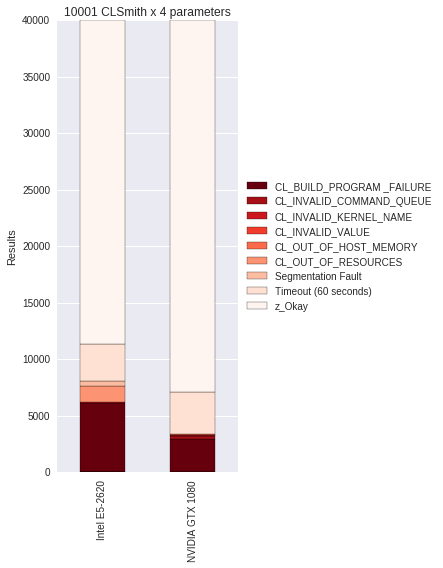

In [25]:
plot_outcomes(CLSmithResult, "CLSmith")

### CLSmith w. cldrive

In [26]:
outcomes["CLSmith w. cldrive"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Unsupported Program,9169,94.789621
1,NVIDIA GTX 1080,z_Okay,462,4.776181
2,NVIDIA GTX 1080,No OpenCL kernel,19,0.196423
3,NVIDIA GTX 1080,cldrive Error,15,0.155071
4,NVIDIA GTX 1080,Timeout (60 seconds),4,0.041352
5,NVIDIA GTX 1080,clWaitForEvents(),1,0.010338
6,NVIDIA GTX 1080,Segmentation Fault,1,0.010338
7,NVIDIA GTX 1080,None,0,0.000000
8,Intel E5-2620,Unsupported Program,13439,94.854602
9,Intel E5-2620,z_Okay,672,4.743083


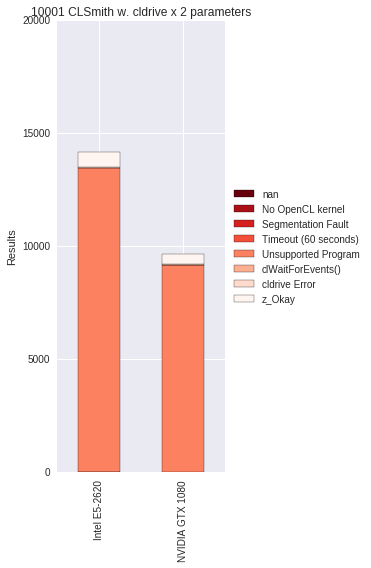

In [27]:
plot_outcomes(cldriveCLSmithResult, "CLSmith w. cldrive")

### GitHub

In [28]:
outcomes["GitHub"]
# set(outcomes["GitHub"]["Outcome"].values)

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Unsupported Program,1657,35.277837
1,NVIDIA GTX 1080,z_Okay,1284,27.336598
2,NVIDIA GTX 1080,cldrive Error,685,14.583777
3,NVIDIA GTX 1080,Multiple OpenCL kernels,501,10.666383
4,NVIDIA GTX 1080,No OpenCL kernel,422,8.984458
5,NVIDIA GTX 1080,Preprocessing Failed,75,1.596764
6,NVIDIA GTX 1080,INVALID_WORK_GROUP_SIZE,34,0.723866
7,NVIDIA GTX 1080,clWaitForEvents(),30,0.638706
8,NVIDIA GTX 1080,Timeout (60 seconds),8,0.170321
9,NVIDIA GTX 1080,OUT_OF_HOST_MEMORY,1,0.021290


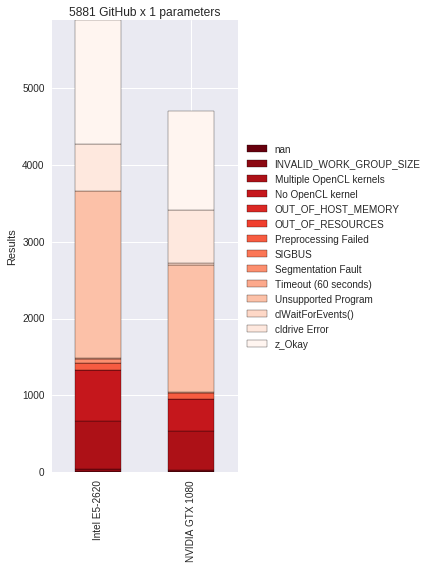

In [29]:
plot_outcomes(GitHubResult, "GitHub")

### CLgen

In [30]:
outcomes["CLgen"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,z_Okay,3994,99.85
1,NVIDIA GTX 1080,clWaitForEvents(),6,0.15
2,Intel E5-2620,z_Okay,3984,99.60
3,Intel E5-2620,Segmentation Fault,16,0.40


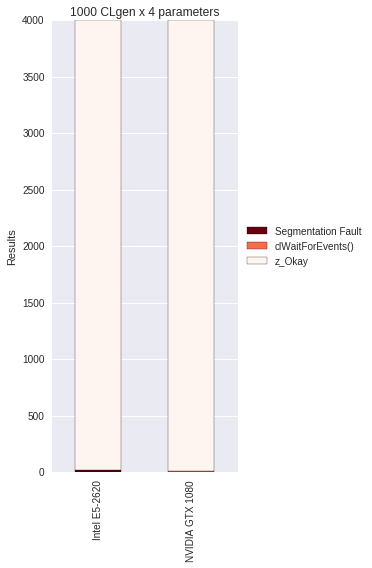

In [31]:
plot_outcomes(CLgenResult, "CLgen")

## TODO...

In [18]:
# q = session.query(CLgenResult).filter(CLgenResult.outcome == "Segmentation Fault")
# for r in q:
#     print(r.program_id)
#     print(r.program.src)

In [19]:
# for param in session.query(CLSmithParams).all():
#     suspicious = []

#     print("Params:", param)
#     programs_with_results = session.query(CLSmithProgram).filter(
#         CLSmithProgram.id.in_(session.query(CLSmithResult.program_id).filter(CLSmithResult.params_id == param.id)))
#     programs_with_good_results = session.query(CLSmithProgram).filter(
#         CLSmithProgram.id.in_(session.query(CLSmithResult.program_id).filter(
#             CLSmithResult.params_id == param.id, CLSmithResult.status == 0)))
#     ratio_good = programs_with_good_results.count() / programs_with_results.count()

#     print("  #. programs with results", programs_with_results.count())
#     print("  #. programs with good results", programs_with_good_results.count(), f"({ratio_good:.1%} of total)")

#     for program in programs_with_good_results.all():
#         q = session.query(CLSmithResult).filter(
#                 CLSmithResult.program_id == program.id, CLSmithResult.params_id == param.id)

#         stdout = set(r.stdout for r in q.all())
#         if len(stdout) > 1:
#             suspicious.append(q.first().program_id)

#     nsuspicious = len(suspicious)
#     ratio_suspicious = nsuspicious / programs_with_good_results.count()
#     print(f"  #. suspicious {nsuspicious} ({ratio_suspicious:.1%} of total)\n")